# QuipuNet: binding reader

A copy of "QuipuNet: barcode reader" with adaptations for reading the sensing region state. Please see the main notebook for detailed descriptions.

In [13]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import matplotlib, seaborn
import h5py
import scipy
import time
import sklearn

import Quipu
from Quipu.kerasHelpers import resetHistory, nextEpochNo
from Quipu.tools import normaliseLength
from Quipu import augment

import keras
from keras import layers
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Embedding
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard


In [2]:
# Graphics configuration 

%matplotlib inline
%config InlineBackend.figure_format='retina'

# general plotting config
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 10}
matplotlib.rc('font', **font)

In [ ]:
# Load cleaned datasets

dataset =         pd.concat([ 
    pd.read_hdf("data/dataset_part1.hdf5"),
    pd.read_hdf("data/dataset_part2.hdf5")
])
datasetTestEven = pd.read_hdf("data/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("data/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("data/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.concat([ 
    pd.read_hdf("data/datasetWithAntibodies_part1.hdf5"),
    pd.read_hdf("data/datasetWithAntibodies_part2.hdf5")
])
datasetExtra =    pd.read_hdf("data/datasetExtra.hdf5")

print("Fraction of used data: ", dataset.Filter.sum()/ len(dataset))

In [3]:
# Load datasets (RAW)

dataset =         pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/dataset.hdf5")
datasetTestEven = pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestEven.hdf5")
datasetTestOdd =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestOdd.hdf5")
datasetTestMix =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetTestMix.hdf5")
datasetWithAntibodies =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetIndividualWithAntibodies.hdf5")
datasetMultiplexed =  pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetMultiplexed.hdf5")
datasetExtra =    pd.read_hdf("/home/kmisiunas/Data/DNA_barcode/datasetExtra.hdf5")

datasetFolds = pd.read_hdf("/home/kmisiunas/Data/folds/dataset.hdf5")
dataset1Peak = pd.read_hdf("/home/kmisiunas/Data/1peak_middle/dataset.hdf5")

print("Fraction of used data: ", dataset.Filter.sum()/ len(dataset))

Fraction of used data:  0.7078922040423484


---

# Neural Network

## Hyper-parameters

Store hyper parameters in `hp` dictionary for easy modification later

In [4]:
# Hyperparameters

hp = {
    "traceLength" : 700,
    "traceTrim"   : 0,
    "barcodes"    : 8,        # distinct barcode count 
    "normalise_levels": True, # wherther to normalise experiments per batch before feetingh into NN
}


# Helper functions

def prepareTraces(dataset):
    "trims, clips, and reformats the traces"
    traces = dataset.trace
    traces_uniform = traces.apply(lambda x: normaliseLength(x, length = hp["traceLength"], trim = hp["traceTrim"]))
    if hp["normalise_levels"]:
        traces_normalised =  - traces_uniform / dataset.UnfoldedLevel                     
        return np.vstack( traces_normalised )
    else:
        return np.vstack( traces_uniform )
    
def prepareLabels(dataset): 
    "prepare barcode labels for training and testing"
    return False # todo
    
    

### Independent test set?

Can we have truly independent test set? Our problem is high correlation between traces performed with the same nanopore (ie same baseline, length). Thus it could be that our current (2017-10-31) test set is not entirely independent. Here, we assess opportunity to make it independent. 

In [5]:
## Test set selection tool  

tmp = pd.concat([
    dataset[dataset.Filter][["barcode", "nanopore", "Bound"]].copy() ,
    datasetExtra[dataset.Filter][["barcode", "nanopore", "Bound"]].copy(),
    datasetWithAntibodies[datasetWithAntibodies.Filter][["barcode", "nanopore", "Bound"]].copy()
], ignore_index = True)
tmp = tmp.groupby(tmp.columns.tolist(),as_index=False).size()

tmp2 = pd.concat([
    dataset[dataset.nbell_barcode < 8][["barcode", "nanopore", "Bound"]].copy() 
], ignore_index = True)
tmp2 = tmp2.groupby(tmp2.columns.tolist(),as_index=False).size()

pd.DataFrame({
    "Full": tmp,
    "NBell": tmp2
})

/home/kmisiunas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Full  NBell
barcode nanopore Bound             
000     6        False   253   48.0
        7        False  2172  350.0
        8        False  3498  584.0
        1014     False    71    NaN
        1017     False   105    NaN
001     7        False   838  175.0
        8        False  1737  284.0
        26       True    502    NaN
        27       True   3583    NaN
        28       True    923    NaN
        29       True   1255    NaN
        1053     False   174    NaN
010     7        False  1021  197.0
        9        False   629  106.0
        10       False   768  153.0
        1159     False   104    NaN
011     6        False  1332  281.0
        7        False   702  148.0
        11       False   362   72.0
        12       False   577  112.0
        31       True    899    NaN
        32       True    344    NaN
        33       True   2192    NaN
        35       False   483    NaN
        36       False  1780    NaN
        37       False  1583    NaN
        38       False  1229    NaN
        39       False  1735    NaN
        40       False  2120    NaN
        41       False  1271    NaN
100     7        False   288   57.0
        13       False   631  115.0
        1933     False    66    NaN
101     8        False  1240  232.0
        26       True   1764    NaN
        27       True    924    NaN
        29       True   3494    NaN
        30       True    427    NaN
        1662     False   123    NaN
110     7        False  1161  223.0
        8        False  2702  559.0
        12       False   606  118.0
        13       False  1309  253.0
        14       False  1559  312.0
111     7        False   735  177.0
        8        False  2866  575.0
        9        False   677  175.0
        14       False   665  165.0
        15       False  1092  239.0
        32       True    346    NaN
        34       True   1263    NaN

 ## Prepare training data

In [5]:
# Select Test Set

#  Important: select independant nanopore experiments to avoid 
#  any correlations between the measurements. 

allDatasets = pd.concat([dataset , datasetExtra, datasetWithAntibodies],ignore_index = True)
allDatasets = allDatasets[allDatasets.Filter] # clear bad points


# selected the smallest independent experiments for each barcode 
# testSetIndex = [
#     ('000', 1017),
#     ('001', 1053),
#     ('010', 1159),
#     ('011', 11),
#     ('100', 1933),
#     ('101', 1662),
#     ('110', 12),
#     ('111', 14)
# ]



# # # for bound states 
# testSetIndex = [
#     ('000', 6),
#     ('001', 26),
#     ('010', 9),
#     ('011', 38),
#     ('100', 7),
#     ('101', 1662),
#     ('110', 12),
#     ('111', 32)
# ]




# final selection: different from previous one - use this only after deciding final model
testSetIndex = [
    # barcode, nanopore
    ('000', 6),
    ('001', 26),
    ('010', 1159),
    ('011', 35),  # unbound
    ('011', 32),  # bound
    ('100', 1933),
    ('101', 30),
    ('110', 12),
    ('111', 14)
]


testSetSelection = allDatasets[["barcode", "nanopore"]]\
                        .apply(tuple, axis = 1)\
                        .isin(testSetIndex)

testSet = allDatasets[ testSetSelection ]
trainSet = allDatasets[ ~ testSetSelection ]


In [6]:
# prepare data

print("Trained noise levels:", 
    Quipu.tools.noiseLevels(train = trainSet.trace.apply(lambda x: x[20:]) ) )

X_train = prepareTraces( trainSet )
Y_train_bound =   np.vstack( trainSet.Bound )


# Slit data into training and dev sets(randomly)
ni_train = int( len(X_train)*0.96 ) # training set
ni_dev   = len(X_train) - ni_train  # dev set

randomIndex = np.arange(len(X_train))
np.random.shuffle(randomIndex) 

X_dev = X_train[randomIndex[ni_train:] , :]
Y_dev_bound = Y_train_bound[randomIndex[ni_train:], :]

X_train = X_train[randomIndex[:ni_train],:]
Y_train_bound = Y_train_bound[randomIndex[:ni_train] , :]

# test set is independant
X_test = prepareTraces( testSet )
Y_test_bound = np.vstack( testSet.Bound.values)


# prepare categories
Y_train = Y_train_bound + 0.0
Y_dev   = Y_dev_bound + 0.0
Y_test  = Y_test_bound + 0.0

print("len(X_train) = ", len(X_train) , "   len(Y_train) = ", len(Y_train))
print("len(X_dev) = ", len(X_dev) )
print("len(X_test) = ", len(X_test) )

Trained noise levels: 0.07194168650007052
len(X_train) =  52525    len(Y_train) =  52525
len(X_dev) =  2189
len(X_test) =  3464


In [7]:
# weights

from sklearn.utils import class_weight

labels = np.array([False, True])

weights = class_weight.compute_class_weight('balanced', labels, Y_train_bound.reshape(-1))


pd.DataFrame({
    "Train": pd.Series(Y_train_bound[:,0]).value_counts() ,
    "Dev": pd.Series(Y_dev_bound[:,0]).value_counts() ,
    "Test": pd.Series(Y_test_bound[:,0]).value_counts() ,
    "weights": weights
}) 



,Dev,Test,Train,weights
False,1504,2191,36567,0.718202
True,685,1273,15958,1.645726


## Models

In [8]:
# Model

input_trace = Input(shape=(hp["traceLength"],1), dtype='float32', name='input')

x = Conv1D(64, 7, padding="same")(input_trace)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(64, 7, padding="same")(x)
x = BatchNormalization(axis=1)(x) 
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Conv1D(128, 5, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(128, 5, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Conv1D(256, 3, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = Conv1D(256, 3, padding="same")(x)
x = BatchNormalization(axis=1)(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)


# Bound detector 
#   same model, but single metric output 

output_bound = Dense(1, activation='sigmoid', name='output_barcode')(x)

model = Model(inputs=input_trace, outputs=output_bound)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr=0.001),
    metrics = ['accuracy']
)

shapeX = (-1, hp["traceLength"],1); shapeY = (-1, 1)
tensorboard, history = resetHistory()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [ ]:
model.summary()

In [ ]:
# Main training method

lr = 0.001

for n in range(0,200):
    print("=== Epoch:", n,"===")
    start_time = time.time()
    # data augmentation
    X = np.repeat(X_train, 1, axis=0) # make copies
    Y = np.repeat(Y_train, 1, axis=0)
    X = augment.magnitude(X, std = 0.08) 
    X = augment.stretchDuration(X, std=0.1, probability=0.3)
    X = augment.addNoise( X, std = 0.08) 
    # Learning rate decay
    lr = lr*0.97
    model.optimizer.lr.assign(lr)
    preparation_time = time.time() - start_time
    
    global out_history
    # Fit the model
    out_history = model.fit( 
        x = X.reshape(shapeX), 
        y = Y.reshape(shapeY), 
        batch_size=32, shuffle = True,
        initial_epoch = n,  epochs=n+1, #nextEpochNo(),
        class_weight = weights, # consider commenting it out
        validation_data=(X_dev.reshape(shapeX),  Y_dev.reshape(shapeY)),
        callbacks = [tensorboard, history], verbose = 0
    )
    training_time = time.time() - start_time - preparation_time
    
    # Feedback 
    print('  prep time: %3.1f sec' % preparation_time, 
          '  train time: %3.1f sec' % training_time)
    print('  loss: %5.3f' % out_history.history['loss'][0] ,
          '  acc: %5.4f' % out_history.history['acc'][0] ,
          '  val_acc: %5.4f' % out_history.history['val_acc'][0] 
    #       '  acc: %5.4f' % out_history.history['output_barcode_acc'][0] ,
    #       '  acc (bound): %5.4f' % out_history.history['output_binding_acc'][0] ,
    )
    

In [9]:
model = keras.models.load_model("/home/kmisiunas/Documents/Quipu/models/binding_metric971_2018-04-03_no1.h5")

In [23]:
model.save("/home/kmisiunas/Documents/Quipu/models/binding_metric971_2018-04-03_no1.h5")


# Evaluate the model

In [18]:
# Measure evaluation speed
t0 = time.time()
model.evaluate(x = X_dev.reshape(shapeX),   y = Y_dev,   verbose=False) 
dt = time.time() - t0
print("Evaluation speed: {:.2f} traces/s ".format(len(X_dev) /dt))


Evaluation speed: 4860.94 traces/s 


In [19]:
print("Train:", model.evaluate(x = X_train.reshape(shapeX), y = Y_train_bound, verbose = False) )
print("Dev  :", model.evaluate(x = X_dev.reshape(shapeX),   y = Y_dev_bound,   verbose = False) )
print("Test :", model.evaluate(x = X_test.reshape(shapeX),  y = Y_test_bound,  verbose = False) )


Train: [0.034870771770935144, 0.9864064731080437]
Dev  : [0.07388701256451377, 0.9744175422567383]
Test : [0.08130460981022583, 0.9708429561200924]


The improbement is consistent with our expetations for QuipuNet performance. 

---

# Binding Analysis

In [25]:
# For Binding

def predictionConfidence(prediction):
    "estimates the probability for prediction to be correct"
    if len(prediction.shape) > 1:
        #vector implementation
        return np.apply_along_axis(arr=prediction, axis=1, func1d=predictionConfidence)
    else:
        return np.max([(1-prediction), prediction])
    
def predictionBound(prediction):
    "Returns best prediction"
    return np.round(prediction)
    
def indecesOfbest(predictions, keep = 0.8):
    "gives indeces of the best data, while keeping specified proportion of the data"
    prob = np.apply_along_axis(predictionConfidence, axis=1, arr = predictions)
    return prob.argsort()[ int(len(prob)*(1-keep)):]
    
def evaluateOnlyBest(x, y, keep=0.8, verbose = False):
    "evaluates the best predictions only"
    best = indecesOfbest( model.predict(x) , keep=keep)
    return model.evaluate(x=x[best], y=y[best], verbose = verbose)

def predictOnlyBest(x, y=None, keep=0.8, verbose = False):
    "runs prediction on the best data"
    predictions = model.predict(x, verbose=verbose)
    best = indecesOfbest( predictions, keep=keep)
    if y is None:
        return predictions[best]
    else: 
        return predictions[best], y[best]

In [26]:
# make sure probability estimators are ready

def estimatePrecisionVsDrop(y_true, x_test):
    "Estimates precision and recalland returns in a table"
    
    predictions_raw = model.predict(x_test.reshape(shapeX))
    
    prediction_bound = predictionBound(predictions_raw).reshape(-1)
    prediction_confidence = predictionConfidence(predictions_raw).reshape(-1)
    y_true_numbers = y_true.reshape(-1)
    # put all in one table
    data = pd.DataFrame({
        "prediction": prediction_bound,
        "label": y_true_numbers,
        "confidence": prediction_confidence,
        "correct": prediction_bound == y_true_numbers
    }).sort_values(by=['confidence'])
    
    length = len(data)
    
    def precission(drop):
        return data.correct[drop:].sum() / (length-drop)
    def recall(drop):
         return data.correct[drop:].sum() / (length)
    def data_remaining(drop):
        return (0.0+length-drop) / length
    
    index = range(0,length, int(length/1000))
    
    return pd.DataFrame({
        "Precission": list([precission(i) for i in  index]),
        "Recall":     list([recall(i) for i in index]),
        "Remaining":  list([data_remaining(i) for i in  index])

    })

Accuracy (best80%): 0.9971129556116926


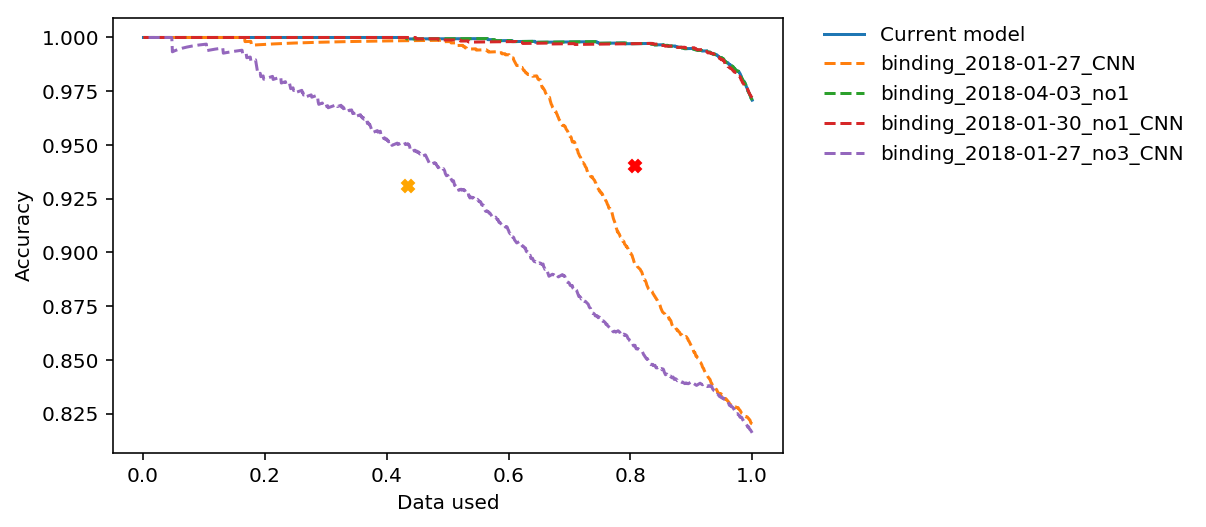

In [27]:
# evaluation

data = estimatePrecisionVsDrop(Y_test_bound,  X_test)

# current model plot on top
pyplot.plot(
    data.Remaining, data.Precission, 
    label='Current model'
)

# human results for comparison (from paper)
pyplot.plot([1.0 - 0.565], [0.931], "X", color='orange')
pyplot.plot([1.0 - 0.192], [0.940], "X", color='red')

# old comparison files
import glob, os
compare_with_files = glob.glob("models/comparison/binding_*.csv")
for file in compare_with_files:
    data2 = pd.read_csv(file)
    pyplot.plot(
        data2.Remaining, data2.Precission, 
        '--',
        label=os.path.basename(file)[:-4]
    )

pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
pyplot.xlabel("Data used")
pyplot.ylabel("Accuracy");


print("Accuracy (best80%):", data.iloc[int( 0.2*len(data) )].Precission)

In [ ]:
# Optional: save model for future comparison
name = "binding_2018-04-03_no1"
data.to_csv("models/comparison/"+name+".csv")

---

## ROC curves

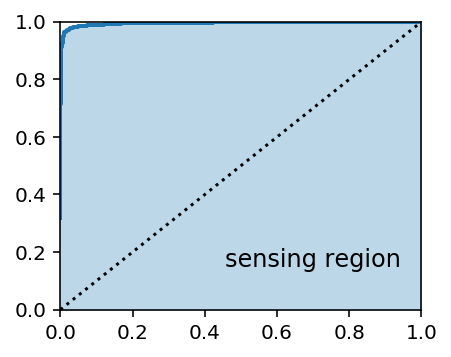

In [18]:
# run on test set

preditions = model.predict(x=X_test.reshape(shapeX))

def roc_curve_for_binding():
    
    y_true = Y_test.reshape(-1)
    y_pred = preditions.reshape(-1)
    return sklearn.metrics.roc_curve(y_true, y_pred)

pyplot.figure(figsize=(11,9))

fpr, tpr, thresholds = roc_curve_for_binding()
pyplot.subplot(3, 3, 9)
pyplot.fill_between(x=fpr, y1=tpr, y2=0, color = '#BCD8E8')
pyplot.plot(fpr, tpr, linewidth=2)
pyplot.xlim([0,1])
pyplot.ylim([0,1])
pyplot.plot([0,1],[0,1], linestyle='dotted', color='black')
pyplot.text(0.7,0.15, "sensing region", horizontalalignment='center', fontsize=12)

pyplot.savefig('images/ROC_curves_sensing_region.pdf')

In [20]:
sklearn.metrics.roc_auc_score(Y_test.reshape(-1), preditions.reshape(-1))

0.995625896556756

--- 

## Error inspection

Manually inspect the mistakes that QuipuNet makes

In [125]:
# TEST: select only the ones that were interpreted as 001, but were 101

X, Y = X_test, np.array(Y_test_labels)
predictions = model.predict(x = X.reshape(shapeX))
confidence = predictionConfidence(predictions)
prediction_barcode = predictionGetBarcodeLabel(predictions)

selection =  (Y != prediction_barcode)
#print("Cases 001 -> 101 fopund:", selection.sum() )


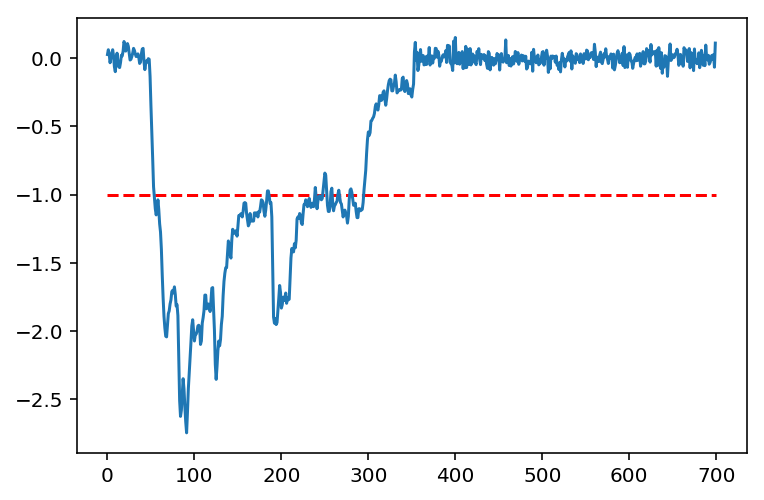

rndId:       1826
Prediction:  011
Confidence:  0.7137761196355565
Label:       001
Correct:     False
label vec  : ['wron' '000 ' '001 ' '010 ' '011 ' '100 ' '101 ' '110 ' '111 ']
vector:      [ 0.000  0.001  0.017  0.005  0.714  0.001  0.179  0.077  0.006]
Bound?:      True
nbell_barcode: nan


In [132]:
# show random sapmple from selection

rndId = np.random.choice( np.arange(len(selection))[selection] )

pyplot.plot([0,700],[-1]*2, 'r--' )
pyplot.plot( X[rndId] )
pyplot.show()

def formatSrt(text):
    if len(text) >= 4:
        return text[:4]
    else:
        return text + (' ' *(4-len(text)))
        
np.set_printoptions( suppress=True, 
                    formatter= {'float': '{: 0.3f}'.format, "bool": '{:>6d}'.format} )

print("rndId:      ", rndId)
print("Prediction: ", prediction_barcode[rndId] )
print("Confidence: ", confidence[rndId] )
print("Label:      ", Y[rndId] )
print("Correct:    ", Y[rndId] == prediction_barcode[rndId] )
print("label vec  :", np.array( list(map(formatSrt, labels))) )
print("vector:     ", predictions[rndId] )
print("Bound?:     ", testSet.iloc[rndId].Bound)
print("nbell_barcode:", numberToLabel( testSet.iloc[rndId].nbell_barcode))

--- 

# Dataset size vs precission



In [38]:
def createTrainingDataset(size):    
    subset = trainSet.sample(size)
    
    X_train = prepareTraces( subset )
    Y_train_bound =   np.vstack( subset.Bound )

    # prepare categories
    Y_train = Y_train_bound + 0.0
    
    return X_train, Y_train

In [39]:
def createQuipuNetModel():
    input_trace = Input(shape=(hp["traceLength"],1), dtype='float32', name='input')

    x = Conv1D(64, 7, padding="same")(input_trace)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(64, 7, padding="same")(x)
    x = BatchNormalization(axis=1)(x) 
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(128, 5, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = Conv1D(256, 3, padding="same")(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)


    # Bound detector 
    #   same model, but single metric output 

    output_bound = Dense(1, activation='sigmoid', name='output_barcode')(x)

    model = Model(inputs=input_trace, outputs=output_bound)

    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(lr=0.001),
        metrics = ['accuracy']
    )
    return model

shapeX = (-1, hp["traceLength"],1); 
shapeY = (-1, 1)

In [44]:
def trainModel():
    lr = 0.001
    for n in range(0,200):
        # data augmentation
        X = np.repeat(X_train, 1, axis=0) # make copies
        Y = np.repeat(Y_train, 1, axis=0)
        X = augment.magnitude(X, std = 0.08) 
        X = augment.stretchDuration(X, std=0.1, probability=0.3)
        X = augment.addNoise( X, std = 0.08) 
        # Learning rate decay
        lr = lr*0.97
        model.optimizer.lr.assign(lr)

        # Fit the model
        out_history = model.fit( 
            x = X.reshape(shapeX), 
            y = Y.reshape(shapeY), 
            batch_size=32, shuffle = True,
            initial_epoch = n,  epochs=n+1, #nextEpochNo(),
            class_weight = weights, # consider commenting it out
            callbacks = [tensorboard, history], verbose = 0
        )


In [45]:
def assessModel(n):
    _, precision80 = evaluateOnlyBest(X_test.reshape(shapeX), Y_test, keep=0.8, verbose = False)
    _, precision100 = evaluateOnlyBest(X_test.reshape(shapeX), Y_test, keep=1.0, verbose = False)
    return [n, precision100, precision80]

In [46]:
output = []

def accuracyForDatasetSize(n):
    
    global model, X_train, Y_train
    
    start_time = time.time()
    
    model = createQuipuNetModel()
    
    X_train, Y_train = createTrainingDataset(n)
    
    trainModel()
    
    ans = assessModel(n)
    
    print("===   N=",n,",  time=", (time.time()- start_time)/60 , "(min)   ===")
    
    print("N={}, Acc(100%)={:.3f}, Acc(100%)={:.3f}".format(n, ans[1], ans[2]))
    
    output.append(ans)
    
    

In [ ]:
ns = [100,200,300,400,600,800,1200,2500,3500]

for n in ns:
    accuracyForDatasetSize(n)
    

===   N= 100 ,  time= 5.896735894680023 (min)   ===
N=100, Acc(100%)=0.720, Acc(100%)=0.751
===   N= 200 ,  time= 6.606947684288025 (min)   ===
N=200, Acc(100%)=0.682, Acc(100%)=0.732
===   N= 300 ,  time= 7.324515223503113 (min)   ===
N=300, Acc(100%)=0.884, Acc(100%)=0.942
===   N= 400 ,  time= 8.106803695360819 (min)   ===
N=400, Acc(100%)=0.889, Acc(100%)=0.948


In [57]:
output

[[500, 0.9310046189376443, 0.9769119768259673],
 [1000, 0.9191685912240185, 0.9689754688894594],
 [1500, 0.9301385681293303, 0.974025974025974],
 [2000, 0.9497690531177829, 0.983044733044733],
 [3000, 0.9480369515011547, 0.9776334776334776],
 [4000, 0.956986143187067, 0.9884559884559885],
 [5000, 0.9618937644341802, 0.987012987012987],
 [7000, 0.9598729792147807, 0.9931457431457431],
 [10000, 0.9696882217090069, 0.9935064935064936],
 [15000, 0.9714203233256351, 0.9949494949494949],
 [20000, 0.9725750577367206, 0.996031746031746],
 [25000, 0.9725750577367206, 0.9978354978354979],
 [30000, 0.9743071593533488, 0.9967532467532467],
 [40000, 0.9771939953810623, 0.9978354978354979],
 [50000, 0.9665127020785219, 0.9949494949494949],
 [100, 0.7199769053117783, 0.751082250910232],
 [200, 0.6821593533487298, 0.7323232324092419],
 [300, 0.8836605080831409, 0.941558441472432],
 [400, 0.8891454965357968, 0.9476911976911977],
 [600, 0.8871247113163973, 0.9534632033771939],
 [800, 0.9408198614318707,

In [60]:
output_np = np.array(output)

output_pd = pd.DataFrame({
    "n" : output_np[:,0],
    "precision100" : output_np[:,1],
    "precision80" : output_np[:,2],
}).sort_values('n')

output_pd.to_csv('sweep/no_of_samples/2018-05-18_barcode.csv')


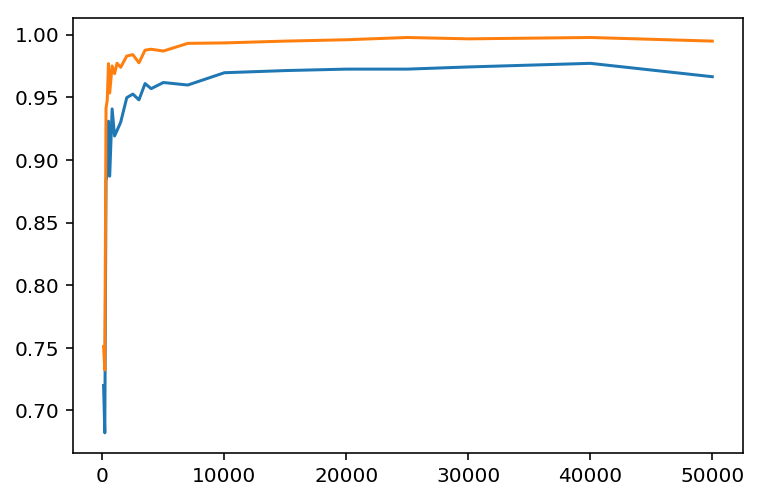

In [61]:
pyplot.plot( output_pd.n, output_pd.precision100 )
pyplot.plot( output_pd.n, output_pd.precision80 )

In [1]:
1+1

2

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

im = np.random.randn(100,100)
image = plt.imshow(im, interpolation='None', animated=True)

def function_for_animation(frame_index):
    im = np.random.randn(100,100)
    image.set_data(im)
    ax.set_title(str(frame_index))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=200, frames=10, blit=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/home/kmisiunas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/kmisiunas/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/kmisiunas/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1498, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
